In [2]:
##-----------------------------------------------------
## Summary : classify hand written digits using logits
## Author  : Venkata Srinivas Vemprala
## SourceCode : https://github.com/Hvass-Labs/TensorFlow-Tutorials
##-----------------------------------------------------

%matplotlib inline      
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix


In [3]:
## Importing the handwritten data from tensorflow
from tensorflow.examples.tutorials.mnist import input_data
data = input_data.read_data_sets('data/MNIST/',one_hot=True)

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting data/MNIST/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting data/MNIST/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting data/MNIST/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting data/MNIST/t10k-labels-idx1-ubyte.gz


In [4]:
## Lets print the size of the various datasets
print('Sizes of datasets : ')
print('Training DataSet : ', len(data.train.labels))
print('Testing DataSet : ', len(data.test.labels))
print('Validation DataSet : ',len(data.validation.labels))

Sizes of datasets : 
Training DataSet :  55000
Testing DataSet :  10000
Validation DataSet :  5000


In [30]:
## Declaring constants
img_size = 28
img_shape = (img_size,img_size)
img_size_flat = img_size * img_size
num_classes = 10
batch_size = 100

trueLabelsTrain = np.array([label.argmax() for label in data.train.labels])
trueLabelsTest = np.array([label.argmax() for label in data.test.labels])
trueLabelsValidation = np.array([label.argmax() for label in data.validation.labels])

In [31]:
## Lets write a function to display images using Matplotlib

def plotImages(images,trueLabels,predLabels=None):
    assert len(images) == len(trueLabels) == 9
    
    #Create a 3x3 subPlot image
    (fig,axes) = plt.subplots(3,3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)
    
    for i,ax in enumerate(axes.flat):
        # Plot Image
        ax.imshow(images[i].reshape(img_shape),cmap='binary')
        
        if predLabels==None:
            xlabel = "True : "+str(trueLabels[i])
        else:
            xlabel = "True : "+str(trueLabels[i])+" Pred : "+str(predLabels[i])
        
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])

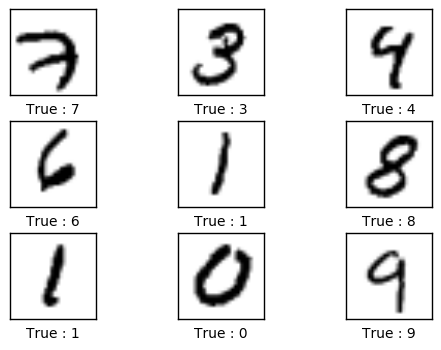

In [32]:
## lets plot few images
images = data.train.images[0:9]
trueLabels = np.array([label.argmax() for label in data.train.labels[0:9]])

plotImages(images,trueLabels)

In [43]:
## Lets write a function to print the confusion Matrix

def print_conf_mat(trueLabels,predLabels):
    cm = confusion_matrix(y_true=trueLabels,y_pred=predLabels)
    print(cm)
    
## Lets write a function to print sample errors
def print_example_errors(images,trueLabels,predLabels):
    correct = np.equal(trueLabels,predLabels)
    indexes = np.where(correct==False)
    
    incorrectImages = images[indexes]
    incorrectTrueLabels = trueLabels[indexes]
    incorrectPredLabels = predLabels[indexes]
    
    plotImages(incorrectImages[0:9],incorrectTrueLabels[0:9],incorrectPredLabels[0:9])

In [49]:
## Lets start creating a tensorflow graph

## Input placeholders
x = tf.placeholder(tf.float32, shape=[None,img_size_flat])
y_true = tf.placeholder(tf.float32, shape=[None,num_classes])

## Variables
w = tf.Variable(tf.zeros([img_size_flat,num_classes]))
b = tf.Variable(tf.zeros([num_classes]))

## Model declaration
y = tf.matmul(x,w) + b
y_pred = tf.nn.softmax(y)
y_pred_class = tf.argmax(y_pred,dimension=1)

## CostFunction declaration
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y,labels=y_pred))
correct = tf.equal(tf.argmax(y_true,dimension=1),tf.argmax(y_pred,dimension=1))
accuracy = tf.reduce_mean(tf.cast(correct,tf.float32))

## Optimizer declaration
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.01).minimize(cost)


In [55]:
## Lets start running the graph 
trainLabelsTrue = data.train.labels
testLabelsTrue = data.test.labels


with tf.Session() as session : 
    session.run(tf.global_variables_initializer())
    
    batchSize = 100
    numIterations = int(len(data.train.labels)/batchSize)
    
    for i in range(numIterations):
        [x_batch,y_batch] = data.train.next_batch(batchSize)
        
        feed = {x:x_batch,y_true:y_batch}
        session.run(optimizer,feed_dict=feed)
        
        if(i%50==0):
            accuracyTrain = session.run(accuracy,feed_dict={x:data.train.images,y_true:data.train.labels})
            accuracyTest = session.run(accuracy,feed_dict={x:data.test.images,y_true:data.test.labels})
            
            print('Iteration ',str(i),' : ')
            print('Training accuracy : ',accuracyTrain*100)
            print('Testing accuracy : ',accuracyTest*100)
            
    ##Lets print final accuracy
    
    accuracyTrain = session.run(accuracy,feed_dict={x:data.train.images,y_true:data.train.labels})
    accuracyTest = session.run(accuracy,feed_dict={x:data.test.images,y_true:data.test.labels})
                    
    print('Iteration ',str(i),' : ')
    print('Training accuracy : ',accuracyTrain*100)
    print('Testing accuracy : ',accuracyTest*100)
            

Iteration  0  : 
Training accuracy :  9.89818200469
Testing accuracy :  9.7999997437
Iteration  50  : 
Training accuracy :  9.89818200469
Testing accuracy :  9.7999997437
Iteration  100  : 
Training accuracy :  9.89818200469
Testing accuracy :  9.7999997437
Iteration  150  : 
Training accuracy :  9.89818200469
Testing accuracy :  9.7999997437
Iteration  200  : 
Training accuracy :  9.89818200469
Testing accuracy :  9.7999997437
Iteration  250  : 
Training accuracy :  9.89818200469
Testing accuracy :  9.7999997437
Iteration  300  : 
Training accuracy :  9.89818200469
Testing accuracy :  9.7999997437
Iteration  350  : 
Training accuracy :  9.89818200469
Testing accuracy :  9.7999997437
Iteration  400  : 
Training accuracy :  9.89818200469
Testing accuracy :  9.7999997437
Iteration  450  : 
Training accuracy :  9.89818200469
Testing accuracy :  9.7999997437
Iteration  500  : 
Training accuracy :  9.89818200469
Testing accuracy :  9.7999997437
Iteration  549  : 
Training accuracy :  9.8981